In [75]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

In [76]:
def load_dataset():

    # load training and test data: pixel values for cat images and binary classification output

    with h5py.File('datasets/train_catvnoncat.h5', "r") as train_dataset:
        train_set_x_orig = np.array(train_dataset["train_set_x"][:])
        train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    with h5py.File('datasets/test_catvnoncat.h5', "r") as test_dataset:
        test_set_x_orig = np.array(test_dataset["test_set_x"][:])
        test_set_y_orig = np.array(test_dataset["test_set_y"][:])
        classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_dataset()

y = [1], it's a 'cat' picture.


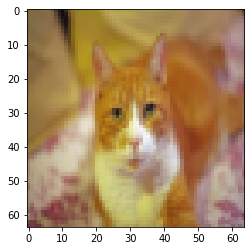

In [77]:
# random showcase of training data
index = np.random.randint(0, train_set_x_orig.shape[0])
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y_orig[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:,index])].decode("utf-8") +  "' picture.")

In [78]:
n_train = train_set_x_orig.shape[0] # number of training examples
n_test = test_set_x_orig.shape[0] # number of test examples
num_pixels = train_set_x_orig.shape[1] # number of pixels = height = width
img_shape = (num_pixels, num_pixels, train_set_x_orig.shape[3]) # height, width, 3 channels (RGB)

print('Number of training patterns: ' + str(n_train))
print('Number of test patterns: ' + str(n_test))
print('Shape of images: ' + str(img_shape))

Number of training patterns: 209
Number of test patterns: 50
Shape of images: (64, 64, 3)


In [79]:
# flatten data and standardize pixel values
# rows represent pixels and columns different training examples

train_x_flatten = train_set_x_orig.reshape(n_train, -1).T
test_x_flatten = test_set_x_orig.reshape(n_test, -1).T

print('Training input dimensions: ' + str(train_x_flatten.shape))
print('Testing input dimensions: ' + str(test_x_flatten.shape))

# distribute the data over the range 0-1
train_x = train_x_flatten / 255
test_x = test_x_flatten / 255

Training input dimensions: (12288, 209)
Testing input dimensions: (12288, 50)


In [101]:
# initialize parameters
def init_params(d):
    return np.zeros((d, 1)), 0

# activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [103]:
# negative log likelihood
def loss_fxn(A, Y, n):
    return (- 1 / n) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

# compute activation, error and gradients
def propagate(w, b, X, Y):
    n = X.shape[1]

    A = sigmoid(np.dot(w.T, X) + b)
    loss = loss_fxn(A, Y, n)

    dw = (-1/n) * np.dot(X, (Y-A).T)
    db = (-1/n) * np.sum(Y-A)
    print(loss)

    return dw, db, loss

def optimize(w, b, X, Y, num_epochs, learning_rate):

    losses = []

    for epoch in range(num_epochs):

        dw, db, loss = propagate(w, b, X, Y)
        w = w - learning_rate * dw
        b = b - learning_rate * db

        if epoch % 100 == 0:
            losses.append(loss)
            print('Epoch {num}, Loss {loss}'.format(num=epoch, loss=loss))

    return w, b, dw, db, losses

def predict(w, b, X):

    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    Y_pred = np.zeros((1, X.shape[1]))

    for idx in range(Y_pred.shape[1]):
        Y_pred[0, idx] = 1 if A[0, idx] > 0.5 else 0 # thresholding
    
    return Y_pred

In [104]:
def model(X_train, Y_train, X_test, Y_test, epoch_num=2500, learning_rate=0.5):
    
    w, b = init_params(X_train.shape[0])
    w_opt, b_opt, dw, db, losses = optimize(w, b, X_train, Y_train, epoch_num, learning_rate)
    Y_pred_train = predict(w_opt, b_opt, X_train)
    Y_pred_test = predict(w_opt, b_opt, X_test)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test - Y_test)) * 100))

model(train_x, train_set_y_orig, test_x, test_set_y_orig)

0.6931471805599453
Epoch 0, Loss 0.6931471805599453
52.55327949559862
nan
nan
30.612364781743125
nan
135.72016178291705
8.717340687621808
nan
115.52919307069226
nan
nan
42.847948845114445
nan
nan
20.93351634852269
nan
126.5567995722756
nan
nan
nan
39.156614693373726
nan
nan
17.36769904572793
nan
124.78604779923933
nan
nan
25.102417184814072
nan
131.20604463925957
nan
nan
nan
27.53690388977046
nan
133.03064391396452
nan
nan
nan
24.889598169602436
nan
131.09490676670268
nan
nan
nan
30.258209245588727
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
111.39753271446224
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Epoch 100, Loss nan
nan
nan
nan
74.50319865581348
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
110.01707702640131
nan
nan
nan
nan
nan
nan
nan
nan
nan
109.43223208850985
nan
nan
nan
nan
n

/var/folders/lz/54h48fsx6294gn68v0q9pp4m0000gn/T/ipykernel_18960/3446175145.py:3: RuntimeWarning: divide by zero encountered in log
  return (- 1 / n) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
/var/folders/lz/54h48fsx6294gn68v0q9pp4m0000gn/T/ipykernel_18960/3446175145.py:3: RuntimeWarning: invalid value encountered in multiply
  return (- 1 / n) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
/var/folders/lz/54h48fsx6294gn68v0q9pp4m0000gn/T/ipykernel_18960/1892619633.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


nan
nan
nan
75.85156915827761
nan
76.8273615218505
nan
71.76676462840608
nan
94.62625722377022
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
72.8251632644183
nan
nan
nan
nan
nan
nan
Epoch 300, Loss nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
64.85703049213394
nan
54.32353504591604
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Epoch 400, Loss nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
